In [8]:
import numpy as np
import torch
import sys
sys.path.append('../')
from voting_games.werewolf_env_v0 import plurality_env, pare, Phase, Roles
import random
import copy
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from notebooks.learning_agents.models import ActorCriticAgent
from notebooks.learning_agents.utils import play_recurrent_game
from notebooks.learning_agents.static_agents import random_approval_wolf, random_plurality_wolf
import notebooks.learning_agents.stats as indicators 
import networkx as nx 

## Replay visualization

We have ways to print out game replays, but a lot of people 

In [2]:
env = plurality_env(num_agents=10, werewolves=2, num_accusations=2)
observations, _, _, _, _ = env.reset()

obs_size= env.convert_obs(observations['player_0']['observation']).shape[-1]

untrained_plurality_agent = ActorCriticAgent({"rec_hidden_size": 128, 
                                        "rec_layers": 1,
                                        "joint_mlp_size": 128,
                                        "split_mlp_size": 128,
                                        "num_votes": 1,
                                        "approval_states": 10},
                                        num_players=10,
                                        obs_size=obs_size)

trained_plurality_agent = ActorCriticAgent({"rec_hidden_size": 128,
                                        "rec_layers": 1, 
                                        "joint_mlp_size": 128,
                                        "split_mlp_size": 128,
                                        "num_votes": 1,
                                        "approval_states": 10},
                                        num_players=10,
                                        obs_size=obs_size)
trained_plurality_agent.load_state_dict(torch.load("stored_agents/lstm_first_no_one_hot_128_128/plurality_agent_10_score_46"))

# random_agent = None

trained_plurality_wins, trained_plurality_replays = play_recurrent_game(env, random_plurality_wolf, trained_plurality_agent, num_times=10, hidden_state_size=128, voting_type="plurality")

In [6]:
replay = trained_plurality_replays[0]

In [ ]:
# https://towardsdatascience.com/building-interactive-network-graphs-using-pyvis-5b8e6e25cf64

In [74]:
def viz_replay(replay):
    #[wolf for wolf in stage["werewolves"]]
    wolves = replay[0]['werewolves']
    villagers = replay[0]['villagers']

    day_info = {}

    pos = None
    color_map = []

    vote_rounds = []
    for i, phase in enumerate(replay):
        if phase["phase"] == Phase.VOTING:
            vote_rounds.append(phase)
        if i == 0:

            # setup the first graph for the position and color map
            G = nx.DiGraph()
            wolf_nodes = [(id, {'color': 'purple'}) for id in wolves]
            villager_nodes = [(id, {'color': 'green'}) for id in villagers]
            G.add_nodes_from(wolf_nodes)
            G.add_nodes_from(villager_nodes)

            if len(color_map) == 0:
                for node in G:
                    if 'color' in G.nodes[node]:
                        color_map.append(G.nodes[node]['color'])
                    else:
                        color_map.append('blue')

            if pos == None:
                pos = nx.spring_layout(G)
            continue
    
        if phase['day'] not in day_info.keys():
            day_info[phase['day']] = []

            # 
        if phase["phase"] == Phase.VOTING:
            if len(vote_rounds) == 1:
                dead_players = []
                # dead_wolves = []
                executed_this_round = phase['executed'][0]
            else:
                dead_players = list((set(phase['executed']) & set(vote_rounds[-2]['executed'])) | set(phase['killed']))
                # dead_wolves = list(set(wolves) & set(dead_players))
                executed_this_round = list(set(phase['executed']) - set(vote_rounds[-2]['executed']))[0]
        else:
            dead_players = list(set(phase['executed']) | set(phase['killed']))
            # dead_wolves = list(set(wolves) & set(dead_players))
            executed_this_round = None

        G = nx.DiGraph()
        wolf_nodes = [(id, {'color': 'purple'}) for id in wolves]
        villager_nodes = [(id, {'color': 'green'}) for id in villagers]
        G.add_nodes_from(wolf_nodes)
        G.add_nodes_from(villager_nodes)

        # edges for plurality
        edges = [(voter, f'player_{target}') for voter, target in phase['votes'].items() if target != len(wolves) + len(villagers)]
        G.add_edges_from(edges)

        day_info[phase['day']].append(G)

    return day_info, pos, color_map

viz_info, pos, cmap = viz_replay(replay)

In [75]:
day_num = len(viz_info.keys())
print(day_num)
phases_per_day = len(list(viz_info.values()))
print(phases_per_day)

4
4


In [76]:
viz_info

{1: [<networkx.classes.digraph.DiGraph at 0x7f232846ada0>,
 2: [<networkx.classes.digraph.DiGraph at 0x7f2328469780>,
 3: [<networkx.classes.digraph.DiGraph at 0x7f2328469090>,
 4: [<networkx.classes.digraph.DiGraph at 0x7f2328468a30>,
  <networkx.classes.digraph.DiGraph at 0x7f2328469180>]}

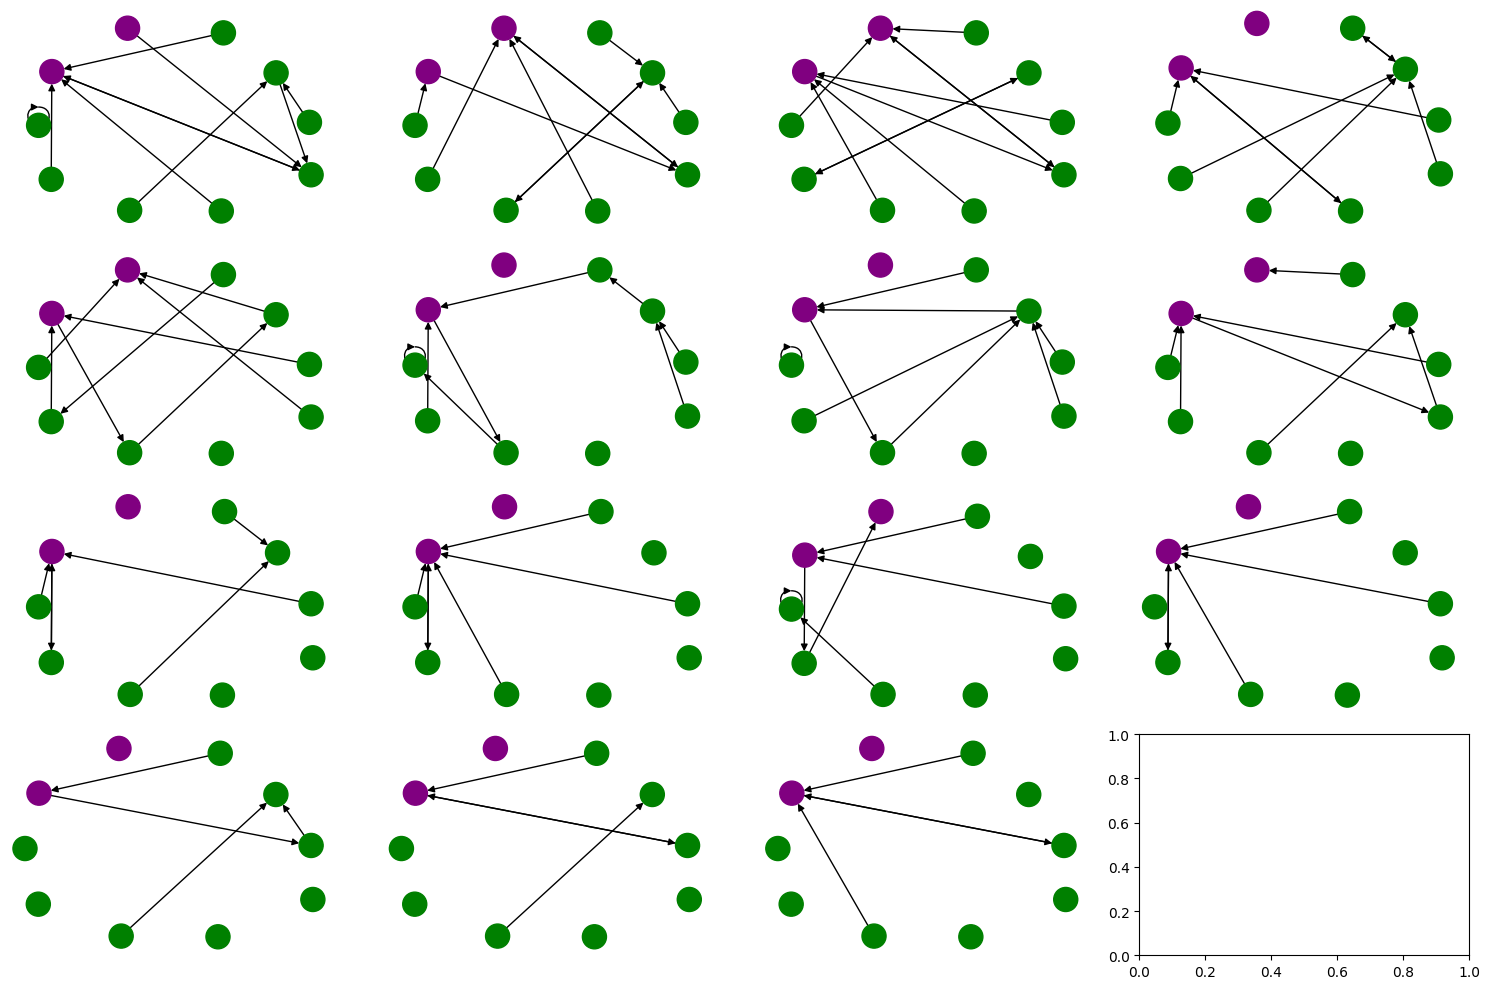

In [77]:
fig, ax = plt.subplots(day_num,phases_per_day, figsize=(15,10))

for day in range(1,day_num+1):
    for j, graph in enumerate(viz_info[day]):
        
        nx.draw(viz_info[day][j], pos, ax=ax[day-1][j], node_color=cmap)

        fig.tight_layout()
plt.show()


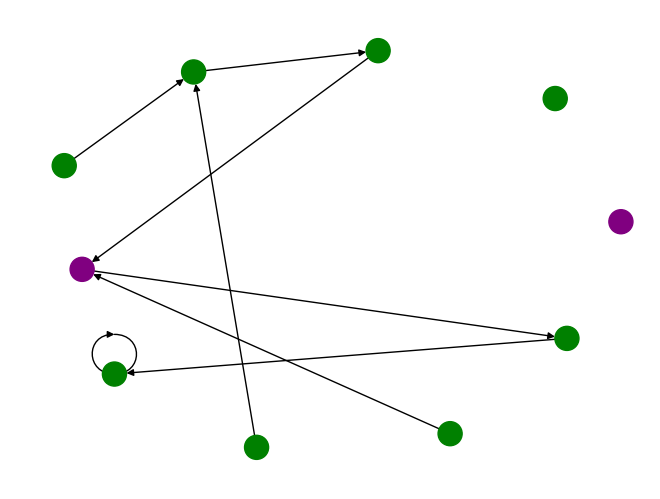

In [47]:
nx.draw(viz_info[2][1], pos, node_color=cmap)